# Lambda School Data Science - Logistic Regression

Logistic regression is the baseline for classification models, as well as a handy way to predict probabilities (since those too live in the unit interval). While relatively simple, it is also the foundation for more sophisticated classification techniques such as neural networks (many of which can effectively be thought of as networks of logistic models).

## Assignment - real-world classification

We're going to check out a larger dataset - the [FMA Free Music Archive data](https://github.com/mdeff/fma). It has a selection of CSVs with metadata and calculated audio features that you can load and try to use to classify genre of tracks. To get you started:

In [48]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
pd.set_option('display.max_columns', None)  # Unlimited columns
import missingno as msno # Missing data visualizer
%matplotlib inline
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split

# Data cleanup

In [12]:
# The first line contains the names for all the columns except for the very first one, which is somehow alone
# in the second row.

# Take columns names from first row
tracks = pd.read_csv('tracks.csv', header=1)

# Manually name the first column, and remove the first line where that name used to be.
tracks.rename(columns={'Unnamed: 0':'track_id'}, inplace=True)
tracks.drop(index=0, inplace=True)
tracks.head()

# Put the genre_top column at the beginning
tracks = tracks.reindex(columns=(['genre_top'] + list([a for a in tracks.columns if a != 'genre_top'])))

# Remove any columns that don't have an entry for genre_top
tracks = tracks.dropna(subset=['genre_top'])

In [14]:
print(tracks.shape)
tracks.head()

(49598, 53)


,genre_top,track_id,comments,date_created,date_released,engineer,favorites,id,information,listens,producer,tags,title,tracks,type,active_year_begin,active_year_end,associated_labels,bio,comments.1,date_created.1,favorites.1,id.1,latitude,location,longitude,members,name,related_projects,tags.1,website,wikipedia_page,split,subset,bit_rate,comments.2,composer,date_created.2,date_recorded,duration,favorites.2,genres,genres_all,information.1,interest,language_code,license,listens.1,lyricist,number,publisher,tags.2,title.1
1,Hip-Hop,2,0.0,2008-11-26 01:44:45,2009-01-05 00:00:00,NaN,4.0,1.0,<p></p>,6073.0,NaN,[],AWOL - A Way Of Life,7.0,Album,2006-01-01 00:00:00,NaN,NaN,"<p>A Way Of Life, A Collective of Hip-Hop from...",0.0,2008-11-26 01:42:32,9.0,1.0,40.058324,New Jersey,-74.405661,"Sajje Morocco,Brownbum,ZawidaGod,Custodian of ...",AWOL,The list of past projects is 2 long but every1...,['awol'],http://www.AzillionRecords.blogspot.com,NaN,training,small,256000.0,0.0,NaN,2008-11-26 01:48:12,2008-11-26 00:00:00,168.0,2.0,[21],[21],NaN,4656.0,en,Attribution-NonCommercial-ShareAlike 3.0 Inter...,1293.0,NaN,3.0,NaN,[],Food
2,Hip-Hop,3,0.0,2008-11-26 01:44:45,2009-01-05 00:00:00,NaN,4.0,1.0,<p></p>,6073.0,NaN,[],AWOL - A Way Of Life,7.0,Album,2006-01-01 00:00:00,NaN,NaN,"<p>A Way Of Life, A Collective of Hip-Hop from...",0.0,2008-11-26 01:42:32,9.0,1.0,40.058324,New Jersey,-74.405661,"Sajje Morocco,Brownbum,ZawidaGod,Custodian of ...",AWOL,The list of past projects is 2 long but every1...,['awol'],http://www.AzillionRecords.blogspot.com,NaN,training,medium,256000.0,0.0,NaN,2008-11-26 01:48:14,2008-11-26 00:00:00,237.0,1.0,[21],[21],NaN,1470.0,en,Attribution-NonCommercial-ShareAlike 3.0 Inter...,514.0,NaN,4.0,NaN,[],Electric Ave
3,Hip-Hop,5,0.0,2008-11-26 01:44:45,2009-01-05 00:00:00,NaN,4.0,1.0,<p></p>,6073.0,NaN,[],AWOL - A Way Of Life,7.0,Album,2006-01-01 00:00:00,NaN,NaN,"<p>A Way Of Life, A Collective of Hip-Hop from...",0.0,2008-11-26 01:42:32,9.0,1.0,40.058324,New Jersey,-74.405661,"Sajje Morocco,Brownbum,ZawidaGod,Custodian of ...",AWOL,The list of past projects is 2 long but every1...,['awol'],http://www.AzillionRecords.blogspot.com,NaN,training,small,256000.0,0.0,NaN,2008-11-26 01:48:20,2008-11-26 00:00:00,206.0,6.0,[21],[21],NaN,1933.0,en,Attribution-NonCommercial-ShareAlike 3.0 Inter...,1151.0,NaN,6.0,NaN,[],This World
4,Pop,10,0.0,2008-11-26 01:45:08,2008-02-06 00:00:00,NaN,4.0,6.0,NaN,47632.0,NaN,[],Constant Hitmaker,2.0,Album,NaN,NaN,"Mexican Summer, Richie Records, Woodsist, Skul...","<p><span style=""font-family:Verdana, Geneva, A...",3.0,2008-11-26 01:42:55,74.0,6.0,NaN,NaN,NaN,"Kurt Vile, the Violators",Kurt Vile,NaN,"['philly', 'kurt vile']",http://kurtvile.com,NaN,training,small,192000.0,0.0,Kurt Vile,2008-11-25 17:49:06,2008-11-26 00:00:00,161.0,178.0,[10],[10],NaN,54881.0,en,Attribution-NonCommercial-NoDerivatives (aka M...,50135.0,NaN,1.0,NaN,[],Freeway
10,Hip-Hop,134,0.0,2008-11-26 01:44:45,2009-01-05 00:00:00,NaN,4.0,1.0,<p></p>,6073.0,NaN,[],AWOL - A Way Of Life,7.0,Album,2006-01-01 00:00:00,NaN,NaN,"<p>A Way Of Life, A Collective of Hip-Hop from...",0.0,2008-11-26 01:42:32,9.0,1.0,40.058324,New Jersey,-74.405661,"Sajje Morocco,Brownbum,ZawidaGod,Custodian of ...",AWOL,The list of past projects is 2 long but every1...,['awol'],http://www.AzillionRecords.blogspot.com,NaN,training,medium,256000.0,0.0,NaN,2008-11-26 01:43:19,2008-11-26 00:00:00,207.0,3.0,[21],[21],NaN,1126.0,en,Attribution-NonCommercial-ShareAlike 3.0 Inter...,943.0,NaN,5.0,NaN,[],Street Music


Allright, looks like the column headers are all in order. Now let's get rid of columns that we can't regress on:
1. ID columns (there's at least 2)
2. Columns with text unique to each song (as opposed to category labels)
3. 'members' (because I expect that it'll be perfectly correlated with the band name).
4. 'split', because I'll make my own train/test splits rather than using theirs.
5. The other genre columns, because it's probably cheating to use that as input for the regressor

In [18]:
garbage_columns = ['track_id','id', 'information','comments.1','title','bio',
                   'members','website','wikipedia_page','split','subset',
                   'comments.2','genres','genres_all','information.1','license','title.1']

tracks2 = tracks.drop(columns=garbage_columns)
tracks2.shape

(49598, 36)

 What about missing data?

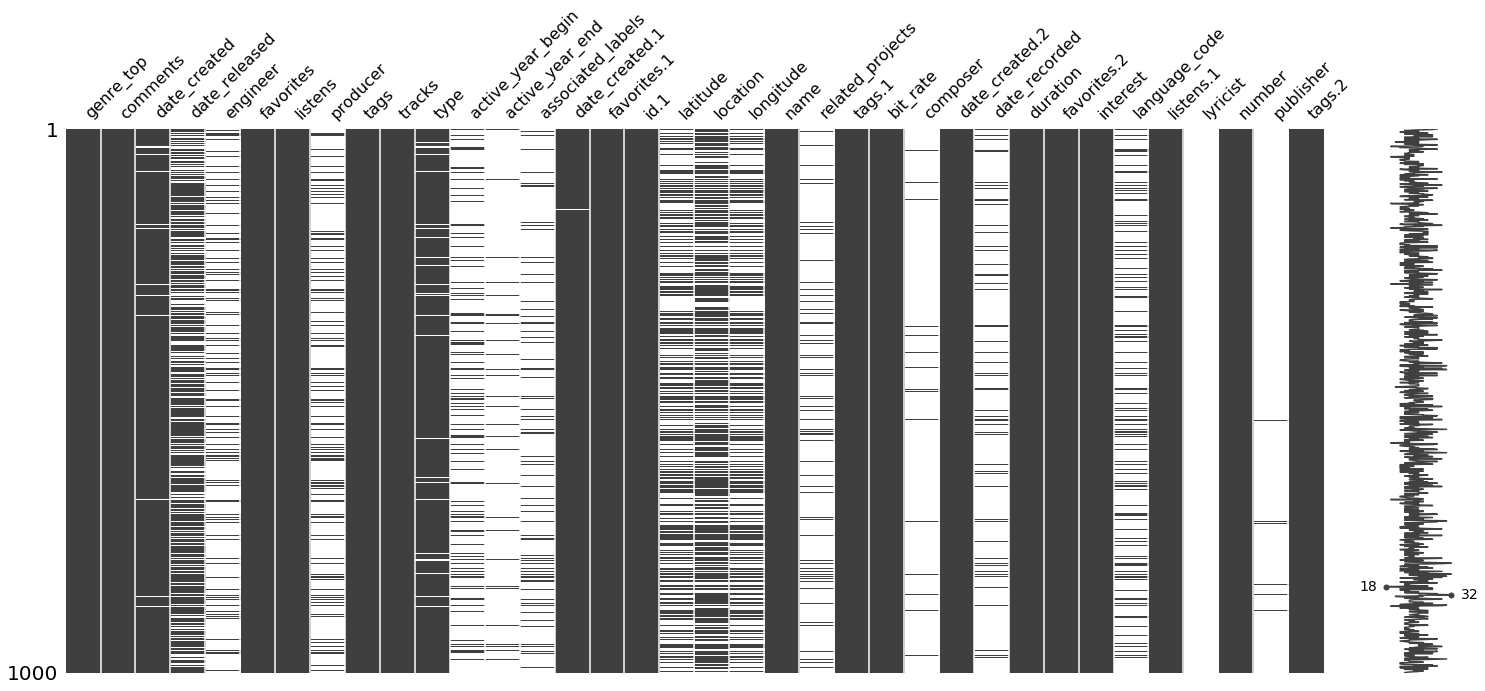

In [19]:
# I sampled 1000 rows from the dataset and used Missingno to graph missing values.
# NaNs are white, data is gray.  Clearly some columns are much more sparse than others.
msno.matrix(tracks2.sample(1000));

I'm tempted to get rid of really sparse columns like 'lyricist', 'publisher', and 'composer', which are empty for 97-99% of the tracks.  However, I'd think that those should have a really high predictive value because particular people are likely to stick to one genre.  I'll keep them for now.

In [24]:
# Percentace of rows with null values for each column
tracks2.isnull().sum() / len(tracks2) * 100

genre_top             0.000000
comments              0.000000
date_created          2.119037
date_released        32.432759
engineer             82.033550
favorites             0.000000
listens               0.000000
producer             79.382233
tags                  0.000000
tracks                0.000000
type                  4.127183
active_year_begin    80.680673
active_year_end      95.165128
associated_labels    87.614420
date_created.1        0.433485
favorites.1           0.000000
id.1                  0.000000
latitude             57.699907
location             35.259486
longitude            57.699907
name                  0.000000
related_projects     89.183032
tags.1                0.000000
bit_rate              0.000000
composer             97.272067
date_created.2        0.000000
date_recorded        91.429090
duration              0.000000
favorites.2           0.000000
interest              0.000000
language_code        81.081898
listens.1             0.000000
lyricist

# Regression 1

Before trying to deal with the remaining NaNs, I'll run a regression with the simplest case: numeric columns that have no missing data.

In [43]:
tracks_full_numeric = tracks2.dropna(axis='columns')
tracks_full_numeric = tracks_full_numeric.select_dtypes('number')
tracks_full_numeric.describe()

,comments,favorites,listens,tracks,favorites.1,id.1,bit_rate,duration,favorites.2,interest,listens.1,number
count,49598.000000,49598.000000,4.959800e+04,49598.000000,49598.000000,49598.000000,49598.000000,49598.000000,49598.000000,4.959800e+04,49598.000000,49598.000000
mean,0.333179,1.145449,1.997469e+04,21.763035,16.721602,11400.403786,260278.657930,268.627263,2.381447,2.523905e+03,1586.328380,8.545607
std,1.312889,2.463242,5.736980e+04,51.492489,58.966302,7046.466624,65663.862632,284.327919,11.147578,1.980285e+04,6039.952955,16.988260
min,-1.000000,-1.000000,-1.000000e+00,-1.000000,-1.000000,1.000000,-1.000000,0.000000,0.000000,2.000000e+00,1.000000,0.000000
25%,0.000000,0.000000,2.602000e+03,7.000000,1.000000,5449.000000,192000.000000,146.000000,0.000000,4.560000e+02,212.000000,2.000000
50%,0.000000,0.000000,6.092000e+03,11.000000,4.000000,11384.000000,256000.000000,211.000000,1.000000,9.380000e+02,520.000000,5.000000
75%,0.000000,1.000000,1.621900e+04,17.000000,12.000000,17450.000000,320000.000000,299.000000,2.000000,2.091000e+03,1321.000000,9.000000
max,17.000000,40.000000,1.193803e+06,652.000000,963.000000,24357.000000,448000.000000,11030.000000,1482.000000,3.293557e+06,543252.000000,255.000000


In [49]:
y = tracks2['genre_top']
X = tracks_full_numeric

# Split into train and test groups
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.5,
                                                   random_state=42)
log_reg = LogisticRegression().fit(X_train, y_train)
log_reg.score(X_test, y_test)

/anaconda3/envs/sandbox/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/anaconda3/envs/sandbox/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:460: FutureWarning: Default multi_class will be changed to 'auto' in 0.22. Specify the multi_class option to silence this warning.
  "this warning.", FutureWarning)
/anaconda3/envs/sandbox/lib/python3.7/site-packages/sklearn/svm/base.py:922: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


0.38541876688576154

In [53]:
tracks_full_numeric.isnull().sum() / len(tracks2) * 100

comments       0.0
favorites      0.0
listens        0.0
tracks         0.0
favorites.1    0.0
id.1           0.0
bit_rate       0.0
duration       0.0
favorites.2    0.0
interest       0.0
listens.1      0.0
number         0.0
dtype: float64

This is the biggest data you've played with so far, and while it does generally fit in Colab, it can take awhile to run. That's part of the challenge!

Your tasks:
- Clean up the variable names in the dataframe
- Use logistic regression to fit a model predicting (primary/top) genre
- Inspect, iterate, and improve your model
- Answer the following questions (written, ~paragraph each):
  - What are the best predictors of genre?
  - What information isn't very useful for predicting genre?
  - What surprised you the most about your results?

*Important caveats*:
- This is going to be difficult data to work with - don't let the perfect be the enemy of the good!
- Be creative in cleaning it up - if the best way you know how to do it is download it locally and edit as a spreadsheet, that's OK!
- If the data size becomes problematic, consider sampling/subsetting
- You do not need perfect or complete results - just something plausible that runs, and that supports the reasoning in your written answers

If you find that fitting a model to classify *all* genres isn't very good, it's totally OK to limit to the most frequent genres, or perhaps trying to combine or cluster genres as a preprocessing step. Even then, there will be limits to how good a model can be with just this metadata - if you really want to train an effective genre classifier, you'll have to involve the other data (see stretch goals).

This is real data - there is no "one correct answer", so you can take this in a variety of directions. Just make sure to support your findings, and feel free to share them as well! This is meant to be practice for dealing with other "messy" data, a common task in data science.

## Resources and stretch goals

- Check out the other .csv files from the FMA dataset, and see if you can join them or otherwise fit interesting models with them
- [Logistic regression from scratch in numpy](https://blog.goodaudience.com/logistic-regression-from-scratch-in-numpy-5841c09e425f) - if you want to dig in a bit more to both the code and math (also takes a gradient descent approach, introducing the logistic loss function)
- Create a visualization to show predictions of your model - ideally show a confidence interval based on error!
- Check out and compare classification models from scikit-learn, such as [SVM](https://scikit-learn.org/stable/modules/svm.html#classification), [decision trees](https://scikit-learn.org/stable/modules/tree.html#classification), and [naive Bayes](https://scikit-learn.org/stable/modules/naive_bayes.html). The underlying math will vary significantly, but the API (how you write the code) and interpretation will actually be fairly similar.
- Sign up for [Kaggle](https://kaggle.com), and find a competition to try logistic regression with
- (Not logistic regression related) If you enjoyed the assignment, you may want to read up on [music informatics](https://en.wikipedia.org/wiki/Music_informatics), which is how those audio features were actually calculated. The FMA includes the actual raw audio, so (while this is more of a longterm project than a stretch goal, and won't fit in Colab) if you'd like you can check those out and see what sort of deeper analysis you can do.